In [18]:
# Різниця між середнім значенням націнки (surcharge) у новорічну ніч та середнім значенням націнки в неділю (groupby, filter).
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, to_date, hour, dayofmonth, month, year, weekday
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [12]:

spark = SparkSession.builder \
    .appName("SurchargeAnalysis") \
    .getOrCreate()

df_fare = spark.read.option("inferSchema", True).option("header", True).parquet("/Users/mac/Development/nyc-taxi-spark-project/trip_fare_cleaned.parquet")
df_trip = spark.read.option("inferSchema", True).option("header", True).parquet("/Users/mac/Development/nyc-taxi-spark-project/trip_data_cleaned.parquet")


In [13]:

df_joined = df_trip.join(df_fare, on=["medallion", "pickup_datetime"])

df_with_time = df_joined \
    .withColumn("trip_date", to_date("pickup_datetime")) \
    .withColumn("pickup_hour", hour("pickup_datetime")) \
    .withColumn("pickup_weekday", weekday("pickup_datetime")) \
    .withColumn("pickup_day", dayofmonth("pickup_datetime")) \
    .withColumn("pickup_month", month("pickup_datetime")) \
    .withColumn("pickup_year", year("pickup_datetime"))


In [14]:

sundays_df = df_with_time.filter(col("pickup_weekday") == 6)

nye_df = df_with_time.filter(
    ((col("pickup_month") == 12) & (col("pickup_day") == 31) & (col("pickup_hour") >= 18)) |
    ((col("pickup_month") == 1) & (col("pickup_day") == 1) & (col("pickup_hour") < 6))
)

avg_surcharge_sunday = sundays_df.agg(avg("surcharge")).first()[0]
avg_surcharge_nye = nye_df.agg(avg("surcharge")).first()[0]
difference = avg_surcharge_nye - avg_surcharge_sunday

result_df = spark.createDataFrame([(
    float(avg_surcharge_nye), 
    float(avg_surcharge_sunday), 
    float(difference)
)], ["avg_nye", "avg_sunday", "difference"])

In [15]:
result_df.coalesce(1).write.mode("overwrite").option("header", True).csv("/Users/mac/Development/nyc-taxi-spark-project/results/3.csv")

/var/folders/vz/rgbmjfqn0nq0nvl3m3c5by_00000gn/T/ipykernel_6251/3039486343.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x="Середня націнка", y="Категорія", palette="flare")


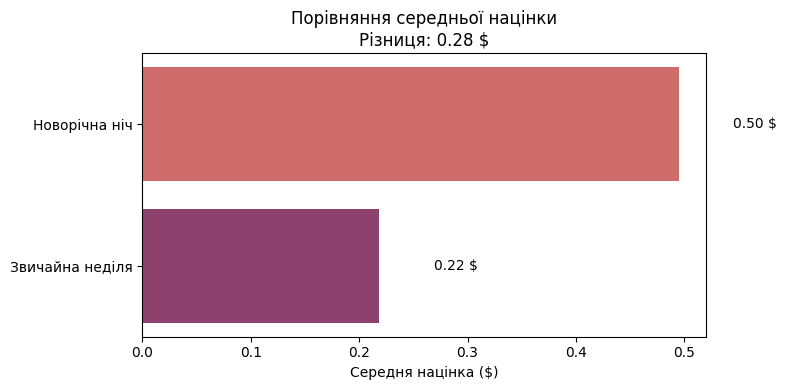

In [19]:
pdf_result = result_df.toPandas()
plot_data = pd.DataFrame({
    "Категорія": ["Новорічна ніч", "Звичайна неділя"],
    "Середня націнка": [pdf_result["avg_nye"][0], pdf_result["avg_sunday"][0]]
})

plt.figure(figsize=(8, 4))
sns.barplot(data=plot_data, x="Середня націнка", y="Категорія", palette="flare")

diff = pdf_result["difference"][0]
plt.title(f"Порівняння середньої націнки\nРізниця: {diff:.2f} $")
plt.xlabel("Середня націнка ($)")
plt.ylabel("")

for index, value in enumerate(plot_data["Середня націнка"]):
    plt.text(value + 0.05, index, f"{value:.2f} $", va='center')

plt.tight_layout()
plt.show()